We downloaded .pdb files from the Protein Data Bank (PDB). Afterwards, these structures were superimposed on PyMOL using 6UEN as the reference. The 'align' command rotates and translates the structure and minimizes the root mean squared of the atoms' positions. The files are exported as "[structure-name]-aligned" and uploaded to Github

Code below finds PDB files that were uploaded on Github and downloads them.

In [2]:
import requests

files = {
    "lp-6uen": "https://raw.githubusercontent.com/nlkeung/pca-protein-structures/refs/heads/main/6uen.pdb",
    "lp-6pzk": "https://raw.githubusercontent.com/nlkeung/pca-protein-structures/refs/heads/main/6pzk-aligned.pdb",
    "lp-lead-8snx": "https://raw.githubusercontent.com/nlkeung/pca-protein-structures/refs/heads/main/8snx-aligned.pdb",
    "lp-tc-8sny": "https://raw.githubusercontent.com/nlkeung/pca-protein-structures/refs/heads/main/8sny-aligned.pdb",
    "lp-mrk1-8fpi": "https://raw.githubusercontent.com/nlkeung/pca-protein-structures/refs/heads/main/8fpi-aligned.pdb",
    "lp-nuc-8fu3": "https://raw.githubusercontent.com/nlkeung/pca-protein-structures/refs/heads/main/8fu3-aligned.pdb"
}

for file_name, file_url in files.items():
    response = requests.get(file_url)
    if response.status_code == 200:
        with open(file_name, 'wb') as file:
            file.write(response.content)
            print(f"{file_name} downloaded successfully.")
    else:
        print(f"Failed to download {file_name}.")

lp-6uen downloaded successfully.
lp-6pzk downloaded successfully.
lp-lead-8snx downloaded successfully.
lp-tc-8sny downloaded successfully.
lp-mrk1-8fpi downloaded successfully.
lp-nuc-8fu3 downloaded successfully.


In [3]:
!pip install biopython
from Bio.PDB import PDBParser
from Bio.SeqUtils import seq1
import numpy as np
import math
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 22.7 MB/s eta 0:00:00


Each protein is made up of a single amino acid chain. However, these PDB structures often contain multiple chains, either another chain of the same protein or a completely different substrate. We are only interested in the chains corresponding to L.

However, the chain IDs might not be the same across different files, so it is hard to find the chain we want. This code extracts the chains each file and prints out the amino acid sequence.

In [4]:
def extract_chains(file_name):
  """

  Extracts amino acid chains from a PDB file and prints the sequences

  Args:
    file_name (str): name of the PDB file to extract chains from

  Returns:
    chains (list): list of Bio.PDB.Chain objects
  """

  parser = PDBParser(QUIET = True)
  structure = parser.get_structure(file_name, file_name)

  chains = []
  for model in structure:
    for chain in model:
      residues = []
      # filtering out heteroatoms found in the list of residues
      for r in chain.get_residues():
        if r.get_id()[0] == " ":
          residues.append(r)
      res_sequence = ""
      for res in residues:
        res_sequence = "".join([res_sequence, seq1(res.get_resname())])
      print(f"Chain {chain.get_id()} has sequence {res_sequence}")
      chains.append(chain)

  return chains

We can now call the method extract_chains() on each of the downloaded files to get the chain sequences. Despite some missing residues, we can very easily see which chain matches with the other chains from the other files. In this case, the longest chain, chain A, is the L protein we're interested in.

In [5]:
print("Chains for 6UEN: ")
extract_chains("lp-6uen")

print("\nChains for 6PZK: ")
extract_chains("lp-6pzk")

print("\nChains for 8SNX: ")
extract_chains("lp-lead-8snx")

print("\nChains for 8SNY: ")
extract_chains("lp-tc-8sny")

print("\nChains for 8FPI: ")
extract_chains("lp-mrk1-8fpi")

print("\nChains for 8FU3: ")
extract_chains("lp-nuc-8fu3")

Chains for 6UEN: 
Chain A has sequence ANVYLTDSYLKGVISFSECNALGSYIFNGPYLKNDYTNLISRQNPLIEHMNLKKLNITQSLISKYHKGEIKLEEPTYFQSLLMTYKSMTSSEQIATTNLLKKIIRRAIEISDVKVYAILNKLGLKEKDKNQSHLKADKNHSTKQKDTIKTTLLKKLMCSMQHPPSWLIHWFNLYTKLNNILTQYRSNEVKNHGFTLIDNQTLSGFQFILNQYGCIVYHKELKRITVTTYNQFLTWKDISLSRLNVCLITWISNCLNTLNKSLGLRCGFNNVILTQLFLYGDCILKLFHNEGFYIIKEVEGFIMSLILNITEEDQFRKRFYNSMLNNITDAANKAQKNLLSRVCHTLLDKTVSDNIINGRWIILLSKFLKLIKLAGDNNLNNLSELYFLFRIFGHPMVDERQAMDAVKINCNETKFYLLSSLSMLRGAFIYRIIKGFVNNYNRWPTLRNAIVLPLRWLTYYKLNTYPSLLELTERDLIVLSGLRFYREFRLPKKVDLEMIINDKAISPPKNLIWTSFPRNYMPSHIQNYIEHEKLKFSESDKSRRVLEYYLRDNKFNECDLYNCVVNQSYLNNPNHVVSLTGKERELSVGRMFAMQPGMFRQVQILAEKMIAENILQFFPESLISKCSIITDLSKFNQAFRYETSCICSDVLDELHGVQSLFSWLHLTIPHVTIICTYRHAPPYIGDHIVDLNNVDEQSGLYRYHMGGIEGWCQKLWTIEAISLLDLISLKGKFSITALINGDNQSIDISKPIRLMEGQTHAQADYLLALNSLKLLYKEYAGIGHKLKGTETYISRDMQFMSKTIQHNGVYYPASIKKVLRVGPWINTILDDFKVSLESIGSLTQELEYRGESLLCSLIFRNVWLYNQIALQLKNHALCNNKLYLDILKVLKHLKTFFNLDNIDTALTLYMNLPMLFGGGDPNLLYRSFYRRTPDFLTEAIVHSVFILSYYTNHDLKDKLQD

[<Chain id=A>, <Chain id=B>, <Chain id=C>, <Chain id=D>, <Chain id=E>]

For our analysis, we will only extract the alpha carbon information from each residue. The alpha carbons give a representation of the protein structure but also allow us to reduce the amount of data needed to be processed.

The function parse_structure extracts informationa about the alpha carbon atoms. It returns the list atoms_info which contains the atom, amino acid (residue), residue number (residue ID), and coordinates.

parse_structure uses helper method parse_chain() and extract_atom_info().

The method `parse_chain()` traverses each residue and atom in the chain and then calls `extract_atom_info()` if it finds an alpha carbon. If it finds an alpha carbon, `parse_chain()` will append information about the atom's name, residue, and coordinates as a single element in a list. Finally, it returns the list after adding all relevant atoms.

In [6]:
def parse_structure(file_name):
  """
  Parses chain A of a given structure and extracts the alpha carbon information

  Args:
    file_name (str): name of the PDB file to extract chains from

  Returns:
    info (list): list of Bio.PDB.Atom objects
  """
  parser = PDBParser(QUIET = True)
  structure = parser.get_structure(file_name, file_name)

  for struct in structure:
    for chain in struct:
      if chain.get_id() == "A":
        # returns a list with elements such as:
        # ('CA', 'ALA', 10, array([ 96.579, 127.576, 132.793], dtype=float32))
        return parse_chain(chain)


def parse_chain(chain):
  """
  Helper method for parse_structure. Creates a list of Bio.PDB.Atom objects
  """
  info = []
  for residue in chain:
    for atom in residue:
      if atom.get_name() == "CA":
        info.append(atom)
  return info

With this code, we can now extract position information from each of the atoms. Printing out the first five atoms from each structure, we can confirm that we have only extracted the alpha carbon information. Looking at the residues, we can also confirm that they match the chain we found initially. Finaly, we can see that the coordinates line up extremely well across the structures. This confirms our alignment on PyMOL worked correctly. This is the data on which we will use PCA to find regions of high variation.

In [7]:
print("6UEN:")
struct1 = parse_structure("lp-6uen")
for atom in struct1[:5]:
  print(atom.get_name(), atom.get_parent().get_id()[1], atom.get_coord())

print("\n6PZK:")
struct2 = parse_structure("lp-6pzk")
for atom in struct2[:5]:
  print(atom.get_name(), atom.get_parent().get_id()[1], atom.get_coord())

print("\n8SNX:")
struct3 = parse_structure("lp-lead-8snx")
for atom in struct3[:5]:
  print(atom.get_name(), atom.get_parent().get_id()[1], atom.get_coord())


print("\n8SNY:")
struct4 = parse_structure("lp-tc-8sny")
for atom in struct4[:5]:
  print(atom.get_name(), atom.get_parent().get_id()[1], atom.get_coord())

print("\n8FPI:")
struct5 = parse_structure("lp-mrk1-8fpi")
for atom in struct5[:5]:
  print(atom.get_name(), atom.get_parent().get_id()[1], atom.get_coord())

print("\n8FU3:")
struct6 = parse_structure("lp-nuc-8fu3")
for atom in struct6[:5]:
  print(atom.get_name(), atom.get_parent().get_id()[1], atom.get_coord())

6UEN:
CA 10 [ 96.579 127.576 132.793]
CA 11 [ 97.427 125.769 129.548]
CA 12 [ 95.985 126.025 126.049]
CA 13 [ 94.302 123.251 124.039]
CA 14 [ 95.011 123.587 120.337]

6PZK:
CA 11 [ 97.841 126.132 129.73 ]
CA 12 [ 96.72  125.511 126.09 ]
CA 13 [ 95.075 122.765 123.994]
CA 14 [ 95.359 122.902 120.179]
CA 15 [ 92.73  120.798 118.354]

8SNX:
CA 10 [ 99.411 126.47  132.07 ]
CA 11 [ 98.912 124.662 128.764]
CA 12 [ 96.62  124.967 125.75 ]
CA 13 [ 94.727 122.273 123.85 ]
CA 14 [ 95.201 122.743 120.098]

8SNY:
CA 10 [ 99.242 126.778 131.811]
CA 11 [ 98.784 124.231 129.017]
CA 12 [ 96.755 124.821 125.85 ]
CA 13 [ 94.875 122.237 123.78 ]
CA 14 [ 95.323 122.537 120.011]

8FPI:
CA 11 [ 98.771 125.107 128.848]
CA 12 [ 96.868 125.42  125.568]
CA 13 [ 94.952 122.903 123.475]
CA 14 [ 95.242 123.136 119.699]
CA 15 [ 92.671 120.975 117.954]

8FU3:
CA 10 [ 99.321 127.793 131.66 ]
CA 11 [ 98.798 125.789 128.502]
CA 12 [ 96.589 125.538 125.442]
CA 13 [ 94.782 122.882 123.487]
CA 14 [ 95.219 123.096 119.755]

The last step in cleaning our data is to make sure to compare the same atoms across the different conformations. To do this, we need to remove an atom from one conformation if it is not found in the others. In Python, the most efficient way to do this is with set operations.

The function `remove_missing_atoms()` takes in a list of structures, and each structure itself is a list of `Bio.PDB.Atom` (see above). The method then constructs a set by inserting the atom's name and residue number. Using set intersection, we can take the intersection of all structures so we are left with only the atoms common to all six. Finally, the function modifies the structures to remove the necessary atoms.

In [8]:
def remove_missing_atoms(all_structs):
  """
  Removes atoms that are not common across all structures using set intersection for efficiency

  Args:
    all_structs (list): list of structures which are themselves a list of Bio.PDB.Atom objects

  Returns:
    filtered_structs (list): list of structures which are a list of Bio.PDB.Atom objects
  """

  set_of_sets = []  # each element is its own set corresponding to one structure

  # For each structure, puts all atoms in a set. Then adds each set to list set_of_sets
  for structure in all_structs:
    all_atoms_set = set()
    for atom in structure:
      atom_ID = (atom.get_name(), atom.get_parent().get_id()[1])
      all_atoms_set.add(atom_ID)
    set_of_sets.append(all_atoms_set)

  # Common atoms is the set intersection of all sets
  common_atoms = set_of_sets[0]
  for i in range(1, len(set_of_sets)):
    common_atoms = common_atoms.intersection(set_of_sets[i])

  # Creates new lists containing the atoms in common_atoms
  filtered_structs = []
  for struct in all_structs:
    new_struct = []
    for atom in struct:
      atom_name = (atom.get_name(), atom.get_parent().get_id()[1])
      if atom_name in common_atoms:
        new_struct.append(atom)
    filtered_structs.append(new_struct)

  return filtered_structs


In [9]:
all_structs = (struct1, struct2, struct3, struct4, struct5, struct6)
all_structs = remove_missing_atoms((all_structs))

residue_ID_list = []
for atom in all_structs[0]:
  residue_ID_list.append(atom.get_parent().get_id()[1])
print("Residues used:", residue_ID_list, "\n")

struct_names = ["6UEN", "6PZK", "8SNX", "8SNY", "8FPI", "8FU3"]

for struct, name in zip(all_structs, struct_names):
  print(name)
  print("Length of struct:", len(struct))
  for atom in struct[:5]:
    print(atom.get_name(), atom.get_parent().get_id()[1], atom.get_coord())
  print()

Residues used: [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275

We can now construct our matrix of coordinate values. We can start by constructing a 3D array. The coordinates array takes in all 6 structures, all atoms, and then the x, y, z coordinates. We can then convert this into a numpy array, giving us the shape

`(number of structures, number of atoms, 3)`.


In [10]:
coords_matrix_3d = []

# constructs a list with the shape:
# coordinates = [ all structures [ all structure coordinates [x, y, z] ] ]
for structure in all_structs:
  struct_coords = []  # stores coordinates for the entire structure

  for atom in structure:
    struct_coords.append(atom.get_coord())  # append the coords for this atom

  coords_matrix_3d.append(struct_coords) # append this stucture's list of coords

# shape: (number of structures, number of atoms, 3)
numpy_3d = np.array(coords_matrix_3d)
print("Shape of numpy array:", numpy_3d.shape)
print("\nFirst structure in arrray:\n", numpy_3d[0])
print("\nFirst atom in array:\n", numpy_3d[0][0])

Shape of numpy array: (6, 1356, 3)

First structure in arrray:
 [[ 97.427 125.769 129.548]
 [ 95.985 126.025 126.049]
 [ 94.302 123.251 124.039]
 ...
 [135.666  81.5   114.275]
 [135.681  84.121 111.501]
 [138.591  82.689 109.503]]

First atom in array:
 [ 97.427 125.769 129.548]


However, to perform PCA, we need a 2D matrix. We can obtain this by flattening our numpy array. We will consider the 6 structures and each of their x, y, and z components as the 18 features. Then, the 1356 atoms will be the data points. This leaves us with an array of size `(18 x 1356)`.

In [11]:
# Flattening the matrix to 2D
# new dimension is 6 (numpy_3d.shape[0])
# -1 tells numpy to calculate what the second dimension based on the number of elements in our original matrix
matrix = numpy_3d.reshape(18, 1356)

print("Shape of matrix:", matrix.shape)
print("First row of matrix:\n", matrix[0])

Shape of matrix: (18, 1356)
First row of matrix:
 [ 97.427 125.769 129.548 ... 111.386  63.991  97.355]


Given our data matrix, we can recenter our data by subtracting each row by the mean of that row. We can also find the covariance matrix `S` which is `18 x 18`.

Then, we can use singular value decomposition (SVD) to find the eigenvalues and eigenvectors for S. The variable `sigma` is a diagonal matrix of the singular values, so squaring each entry will give the eigenvalues of S. We will also get `PT`, and if we transpose this matrix, we will get the matrix `P`. The columns of `P` will give us our principal components.

In [12]:
# Calculating covariance matrix S (18 x 18)
m, n = matrix.shape
S = np.cov(matrix)

# recentering the data matrix in order to use singular value decomposition
recentered_data = 1/math.sqrt(n-1)*(matrix-matrix.mean(axis=1).reshape(-1, 1))
print("First row of recentered data:\n", recentered_data[0])

#performing singular value decomposition to get the PCA transformation matrix Pt
U , sigma, PT = np.linalg.svd(np.transpose(recentered_data))
P = np.transpose(PT)

print('\nThe first column aka Principal Component 1 of matrix P is \n', P[:,0],'\n')

First row of recentered data:
 [-0.03426151  0.7356854   0.838347   ...  0.34495276 -0.9425937
 -0.03621744]

The first column aka Principal Component 1 of matrix P is 
 [ 0.40054742 -0.12145647  0.035435    0.38688534 -0.11600223  0.03515464
  0.38713905 -0.11723006  0.03383568  0.38694632 -0.11657543  0.03361806
  0.3894036  -0.11793799  0.03515346  0.38544822 -0.11570011  0.03511158] 



Here, we find the eigenvalues associated with S. If we divide the first eigenvalue by the total variance, we get the percentage of variance attributed to principal component 1.


Singular values:  [47.902775   45.162506   39.37912     0.4492626   0.4187791   0.38982365
  0.36857623  0.3041304   0.29353008  0.24781628  0.21777245  0.20681037
  0.20039515  0.19298995  0.17802492  0.1581384   0.15123728  0.13070324]

The eigenvalues of S are:  [2.2946758e+03 2.0396520e+03 1.5507151e+03 2.0183687e-01 1.7537594e-01
 1.5196247e-01 1.3584843e-01 9.2495300e-02 8.6159907e-02 6.1412908e-02
 4.7424842e-02 4.2770531e-02 4.0158216e-02 3.7245121e-02 3.1692870e-02
 2.5007751e-02 2.2872714e-02 1.7083338e-02]

The total variance is  5886.212193891406 


PC1 accounts for  38.983911990657916 % of the variance
PC2 accounts for  34.65134980447652 % of the variance
PC3 accounts for  26.344872335725956 % of the variance
PC1, PC2, and PC3 account for  99.98013413086038 % of the variance


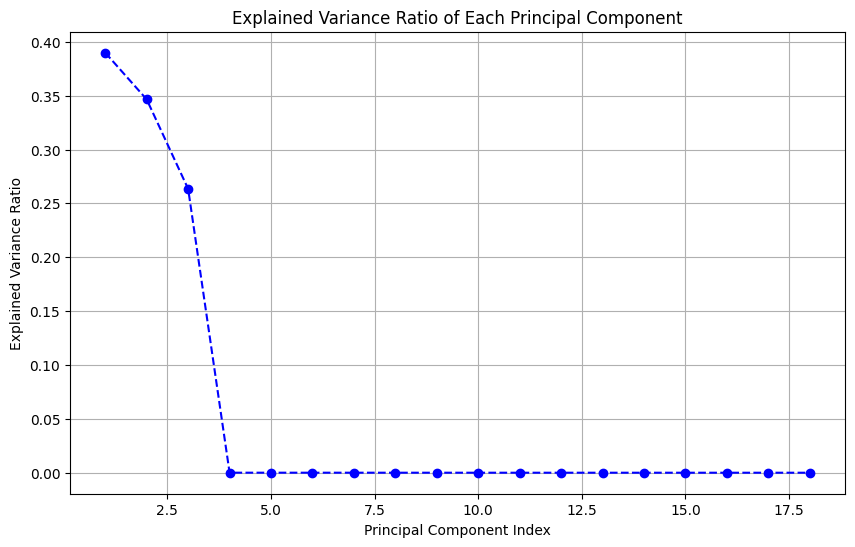

In [13]:
print("\nSingular values: ", sigma)

S_eigenvalues = sigma**2
print("\nThe eigenvalues of S are: ", S_eigenvalues)

total_variance = sum(S_eigenvalues)
print("\nThe total variance is ", total_variance, "\n")

print("\nPC1 accounts for ", 100 * S_eigenvalues[0]/ sum(S_eigenvalues), "% of the variance")
print("PC2 accounts for ", 100 * S_eigenvalues[1]/ sum(S_eigenvalues), "% of the variance")
print("PC3 accounts for ", 100 * S_eigenvalues[2]/ sum(S_eigenvalues), "% of the variance")
print("PC1, PC2, and PC3 account for ", 100 * sum(S_eigenvalues[:3])/ sum(S_eigenvalues), "% of the variance")

# Graphing our results
explained_variance_ratio = S_eigenvalues / total_variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(S_eigenvalues) + 1), explained_variance_ratio, marker='o', linestyle='--', color='b')
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio of Each Principal Component')
plt.grid(True)
plt.show()

So we can see that the top 3 principal components contribute to 99.98% of the variance found in our data

Knowing this, we can simplify our data with the first three principal components. If we only keep the first 3 principal components, P is now `3 x 18`. Using `P^T` as a transformation matrix, we can transform our data using `Y = P^T * X` which gives us a transformed data of dimension `3 x 1356`.

In [14]:
# Reducing and transforming data into new basis
top3_P = P[:, :3]
Y = np.dot(top3_P.T, recentered_data)
print(Y.shape)
Y= Y.T

# Calculating Euclidean norm across the columns of Y
# This is done to tell us how much of the variation from the data was due to each specific atom (the columns of Y)
total_variation = np.sqrt(np.sum(Y**2, axis=1))

# Extracting the top 100 varied atomic indices
top_atoms_indices = np.argsort(total_variation)[-100:]

# Results Output
print("Top 10 Varied Atoms Across All Structures:")
for idx in top_atoms_indices:
    real_index = residue_ID_list[idx]     # re-indexes atoms based on their residue values
    print(f"Atom Index: {real_index}, PC1: {Y[idx, 0]:.3f}, PC2: {Y[idx, 1]:.3f}, PC3: {Y[idx, 2]:.3f}")

(3, 1356)
Top 10 Varied Atoms Across All Structures:
Atom Index: 1295, PC1: -0.118, PC2: -2.886, PC3: 0.925
Atom Index: 1178, PC1: -1.018, PC2: -1.899, PC3: 2.137
Atom Index: 1301, PC1: 0.098, PC2: -2.817, PC3: 1.139
Atom Index: 1348, PC1: -1.886, PC2: -0.821, PC3: -2.240
Atom Index: 24, PC1: 2.170, PC2: 1.879, PC3: 1.005
Atom Index: 1172, PC1: -1.228, PC2: -1.893, PC3: 2.048
Atom Index: 30, PC1: 2.182, PC2: 1.879, PC3: 1.001
Atom Index: 192, PC1: 1.495, PC2: -1.258, PC3: -2.342
Atom Index: 548, PC1: 2.607, PC2: 1.535, PC3: 0.404
Atom Index: 201, PC1: 1.225, PC2: -1.410, PC3: -2.417
Atom Index: 27, PC1: 2.102, PC2: 1.872, PC3: 1.193
Atom Index: 1307, PC1: -0.067, PC2: -2.832, PC3: 1.151
Atom Index: 557, PC1: 2.499, PC2: 1.735, PC3: 0.323
Atom Index: 240, PC1: 0.635, PC2: -1.881, PC3: -2.331
Atom Index: 578, PC1: 2.352, PC2: 1.944, PC3: -0.252
Atom Index: 1282, PC1: -2.472, PC2: -0.213, PC3: -1.796
Atom Index: 231, PC1: 0.812, PC2: -1.746, PC3: -2.388
Atom Index: 213, PC1: 1.011, PC2: -

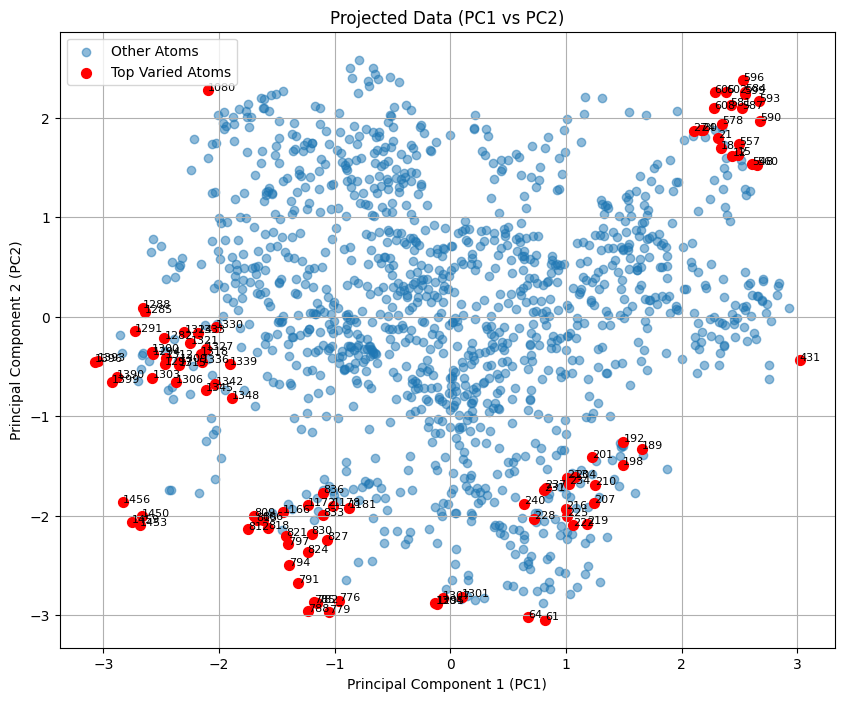

In [19]:
# Visualizing PCA Results
plt.figure(figsize=(10, 8))
plt.scatter(Y[:, 0], Y[:, 1], color = 'C0', alpha=0.5, label='Other Atoms')
plt.scatter(Y[top_atoms_indices, 0], Y[top_atoms_indices, 1],
            color='r', label='Top Varied Atoms', s=50)

# Display atom index
for atom_idx in top_atoms_indices:
    real_index = residue_ID_list[atom_idx]      # Re-indexing so atoms match their residue number
    plt.text(Y[atom_idx, 0], Y[atom_idx, 1], str(real_index), fontsize=8, color='black')

plt.title('Projected Data (PC1 vs PC2)')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.legend()
plt.grid(True)
plt.show()

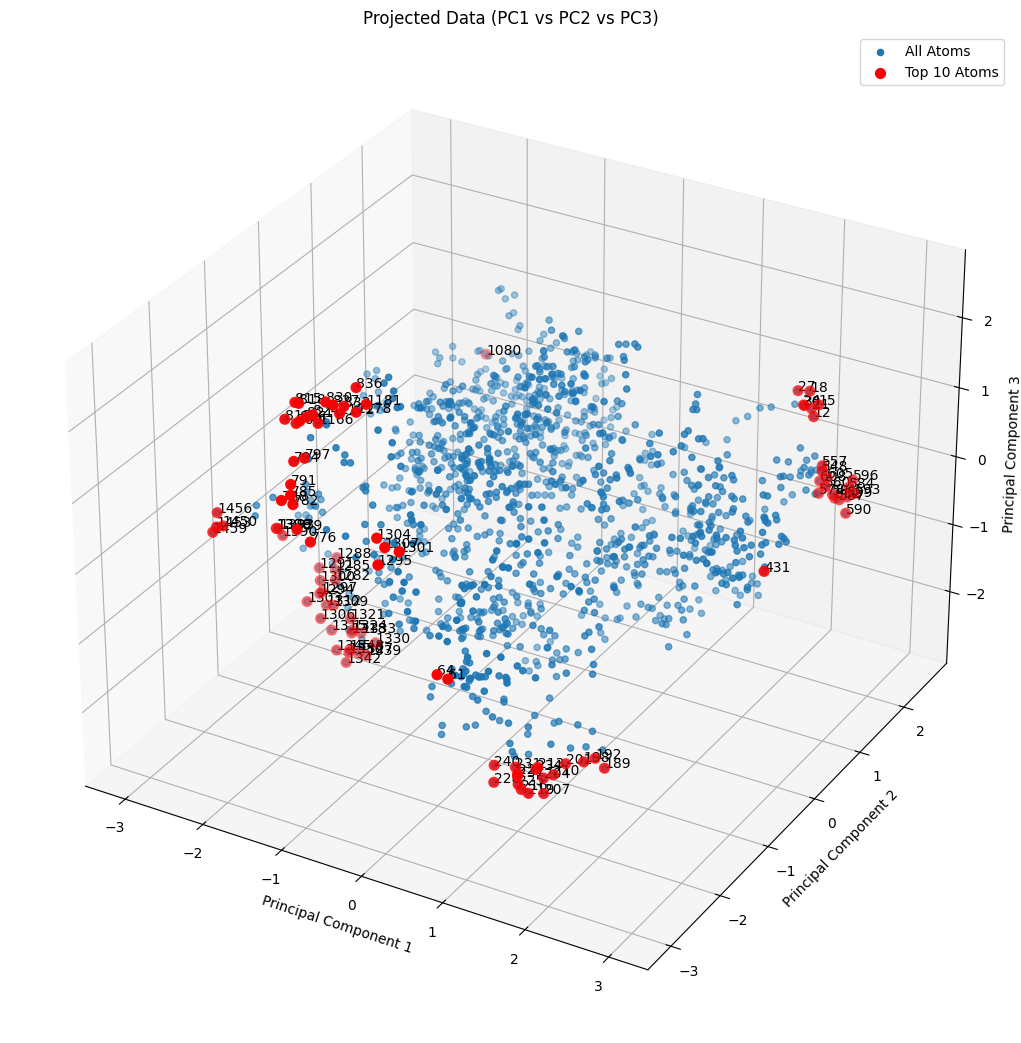

In [16]:
# Creating the 3D scatter plot
fig = plt.figure(figsize=(14, 13))
ax = fig.add_subplot(111, projection='3d')

# Plotting all atoms in light gray
ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], color='C0', label='All Atoms')

# Highlighting the top 10 atoms in red with larger markers
ax.scatter(Y[top_atoms_indices, 0], Y[top_atoms_indices, 1], Y[top_atoms_indices, 2], color='r', s=50, label='Top 10 Atoms')

# Annotating each of the top 10 atoms with its index
for idx in top_atoms_indices:
    real_index = residue_ID_list[idx]     # Re-indexing so atoms match their residue number
    ax.text(Y[idx, 0], Y[idx, 1], Y[idx, 2], f'{real_index}', size=10, color='black')

# Labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('Projected Data (PC1 vs PC2 vs PC3)')

# Adding a legend
ax.legend()

# Show the plot
plt.show()

In [18]:
# Printing out highly variable residues in 10-residue chunks

chunk_size = 10
for i in range(0, len(top_atoms_indices), chunk_size):
    # Group the indices into chunks of size `chunk_size`
    print([residue_ID_list[j] for j in sorted(top_atoms_indices)[i:i+chunk_size]])

[12, 15, 18, 21, 24, 27, 30, 61, 64, 189]
[192, 198, 201, 204, 207, 210, 213, 216, 219, 222]
[225, 228, 231, 234, 237, 240, 431, 548, 557, 560]
[578, 581, 584, 587, 590, 593, 596, 599, 602, 605]
[608, 776, 779, 782, 785, 788, 791, 794, 797, 806]
[809, 812, 815, 818, 821, 824, 827, 830, 833, 836]
[1080, 1166, 1172, 1178, 1181, 1282, 1285, 1288, 1291, 1294]
[1295, 1297, 1300, 1301, 1303, 1304, 1306, 1307, 1309, 1312]
[1315, 1318, 1321, 1324, 1327, 1330, 1333, 1336, 1339, 1342]
[1345, 1348, 1390, 1393, 1396, 1399, 1450, 1453, 1456, 1459]
